# Collaborative Clustering

## Importing Libraries

In [33]:
import math
import numpy as np
import pandas as pd
import warnings
# import pandas_datareader as web
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_mode
#import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, LSTM, Dropout, Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-v0_8-dark')

In [34]:
warnings.filterwarnings('ignore')

### Importing Stocks dataframe

In [35]:
demo_df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/AmazonStock_Sentiment_6M.csv');
demo_df

,date,open,low,high,volume,close,Name,Date,Positve,Negative,Neutral,Total,NeutralPos,NeutralNeg
0,10/2/2017,964.00,952.1201,967.305,2415846,959.19,AMZN,10/2/2017,37.088734,7.577268,55.333998,1003,37.088734,14.260219
1,10/3/2017,958.00,950.3700,963.690,2643484,957.10,AMZN,10/3/2017,38.159879,11.085973,50.754148,1326,38.159879,22.348774
2,10/4/2017,954.21,954.0500,967.790,2460721,965.45,AMZN,10/4/2017,36.168582,10.727969,53.103448,1305,36.168582,19.641470
3,10/5/2017,970.00,969.6400,981.510,3119487,980.85,AMZN,10/5/2017,47.939017,7.227555,44.833427,1771,47.939017,24.411076
4,10/6/2017,975.64,975.6400,995.750,3719840,989.58,AMZN,10/6/2017,34.628045,11.586570,53.785385,1519,34.628045,19.818134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,3/5/2018,1494.24,1481.0000,1525.380,5233934,1523.61,AMZN,3/5/2018,38.274182,7.794015,53.931802,1437,38.274182,15.879162
105,3/6/2018,1533.20,1528.0000,1542.130,4561718,1537.64,AMZN,3/6/2018,45.234604,6.818182,47.947214,1364,45.234604,20.887916
106,3/7/2018,1526.52,1522.5100,1545.900,4174123,1545.00,AMZN,3/7/2018,38.167260,9.786477,52.046263,1124,38.167260,19.757162
107,3/8/2018,1550.00,1545.2500,1554.880,3512528,1551.86,AMZN,3/8/2018,37.221728,8.726625,54.051647,1123,37.221728,16.691926


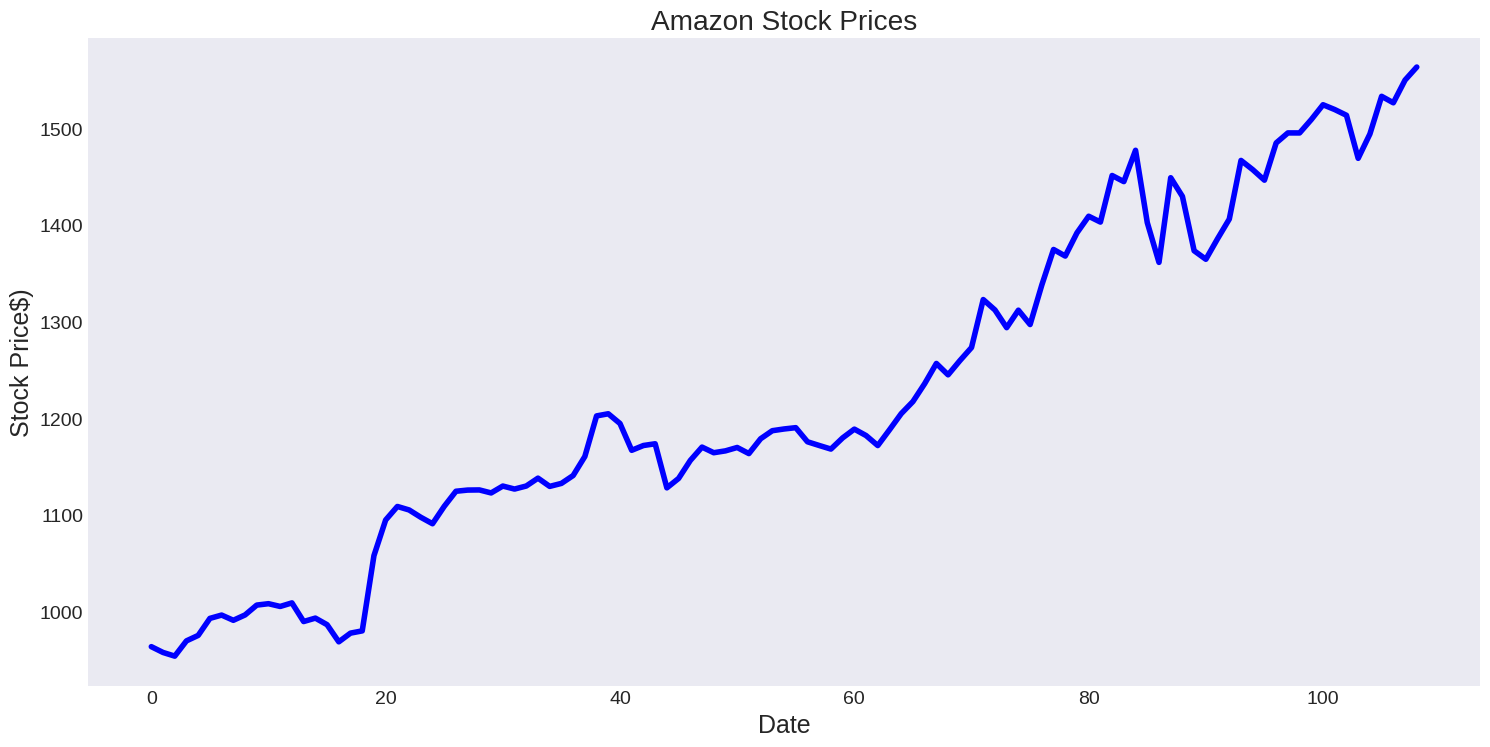

In [36]:
plt.figure(figsize=(16,8))

plt.title('Amazon Stock Prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Price$)', fontsize=18)
plt.plot(demo_df['open'], color='blue')
# plt.savefig('/content/prediction.png')
plt.show()

### Importing general user's decisions in the past

In [37]:
df_decisions_list = []
df_decisions_list.append({'df': pd.read_csv('./amazon_stock_trades.csv'), 'comp': 'AMZN'})
df_decisions_list.append({'df': pd.read_csv('./apple_stock_trades.csv'), 'comp': 'AAPL'})
df_decisions_list.append({'df': pd.read_csv('./cisco_stock_trades.csv'), 'comp': 'CSCO'})
df_decisions_list.append({'df': pd.read_csv('./ibm_stock_trades.csv'), 'comp': 'IBM'})
df_decisions_list.append({'df': pd.read_csv('./jnj_stock_trades.csv'), 'comp': 'JNJ'})
df_decisions_list.append({'df': pd.read_csv('./jnpr_stock_trades.csv'), 'comp': 'JNPR'})
df_decisions_list.append({'df': pd.read_csv('./msft_stock_trades.csv'), 'comp': 'MSFT'})
df_decisions_list.append({'df': pd.read_csv('./orcl_stock_trades.csv'), 'comp': 'ORCL'})
df_decisions_list.append({'df': pd.read_csv('./pfizer_stock_trades.csv'), 'comp': 'PFIZER'})
df_decisions_list.append({'df': pd.read_csv('./tgt_stock_trades.csv'), 'comp': 'TGT'})

## Normalising the decisions based on companies

In [38]:
# scale each df
from sklearn.preprocessing import MinMaxScaler
columns_to_exclude = ['Sector of stock', 'Buy/Sell/Keep']
columns_to_normalize = ['Current Value of Stock', 'Expected Value of Stock', 'Error in expected value of stock', 'Percentage of portfolio', 'Percentage of sector', 'Positive', 'Negative', 'Neutral', 'Total', 'Neutral_Pos', 'Neutral_Neg']
scalers_decisions = []
for i in range(len(df_decisions_list)):
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(df_decisions_list[i]['df'][columns_to_normalize])
    normalized_df = pd.DataFrame(normalized_values, columns=columns_to_normalize)
    scalers_decisions.append({'scaler': scaler, 'comp': df_decisions_list[i]['comp']})

    # Concatenate the normalized DataFrame with the excluded column
    df_decisions_list[i]['df'] = pd.concat([normalized_df, df_decisions_list[i]['df'][columns_to_exclude]], axis=1)

In [39]:
df_decisions_list[i]['df']

,Current Value of Stock,Expected Value of Stock,Error in expected value of stock,Percentage of portfolio,Percentage of sector,Positive,Negative,Neutral,Total,Neutral_Pos,Neutral_Neg,Sector of stock,Buy/Sell/Keep
0,0.177815,0.170312,0.085714,0.374442,0.409737,0.158350,0.250077,0.197368,0.879453,0.483611,0.122179,Consumer Discretionary,Keep
1,0.188617,0.164154,0.000000,0.262191,0.279018,0.313554,0.260908,0.218985,0.747513,0.474938,0.127471,Consumer Discretionary,Sell
2,0.173245,0.158420,0.037363,0.272437,0.864427,0.362809,0.221509,0.188910,0.726102,0.506490,0.108222,Consumer Discretionary,Keep
3,0.173660,0.107241,0.115385,0.868963,0.251976,0.195647,0.559692,0.269737,0.701104,0.235656,0.273447,Consumer Discretionary,Sell
4,0.125883,0.083670,0.246154,0.687174,0.073152,0.404789,0.174487,0.227444,0.714274,0.544148,0.085248,Consumer Discretionary,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.872455,0.831811,0.389011,0.964227,0.301355,0.606196,0.641853,0.095865,0.326535,0.460702,0.491020,Consumer Discretionary,Sell
103,0.794350,0.855808,0.306044,0.986055,0.548348,0.570140,0.452769,0.000000,0.446299,0.411324,0.276136,Consumer Discretionary,Buy
104,0.841712,0.773625,0.942857,0.456054,0.807529,0.416400,0.683732,0.274436,0.461552,0.200784,0.373375,Consumer Discretionary,Keep
105,0.820108,0.698237,0.252747,0.937983,0.322773,0.716076,0.559775,0.772556,0.275992,0.611178,0.502618,Consumer Discretionary,Sell


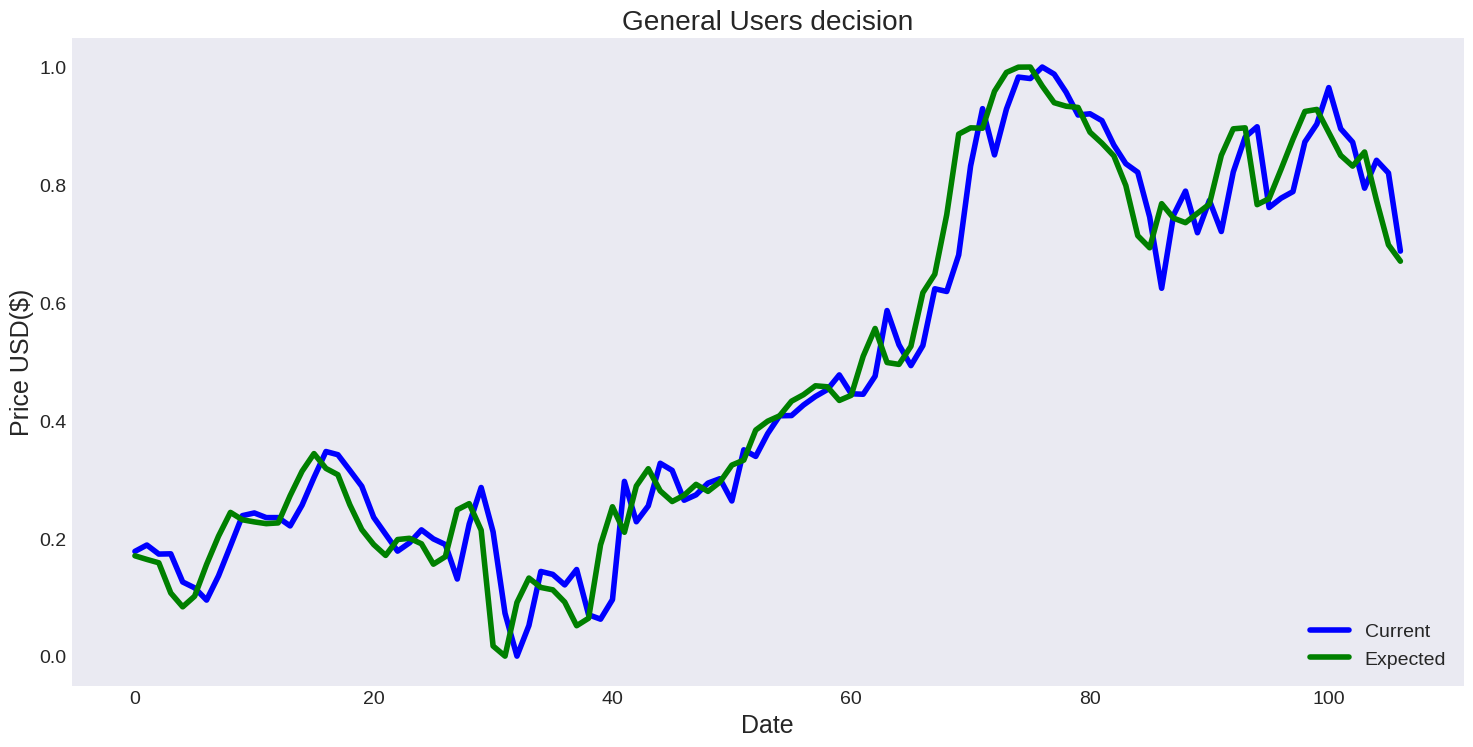

In [40]:


plt.figure(figsize=(16, 8))

plt.title('General Users decision')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD($)', fontsize=18)
plt.plot(df_decisions_list[i]['df']['Current Value of Stock'], color='blue')
plt.plot(df_decisions_list[i]['df']['Expected Value of Stock'], color='green')
plt.legend(['Current', 'Expected'], loc='lower right')
# plt.savefig('/content/prediction.png')
plt.show()

In [41]:
scalers_decisions

[{'scaler': MinMaxScaler(), 'comp': 'AMZN'},
 {'scaler': MinMaxScaler(), 'comp': 'AAPL'},
 {'scaler': MinMaxScaler(), 'comp': 'CSCO'},
 {'scaler': MinMaxScaler(), 'comp': 'IBM'},
 {'scaler': MinMaxScaler(), 'comp': 'JNJ'},
 {'scaler': MinMaxScaler(), 'comp': 'JNPR'},
 {'scaler': MinMaxScaler(), 'comp': 'MSFT'},
 {'scaler': MinMaxScaler(), 'comp': 'ORCL'},
 {'scaler': MinMaxScaler(), 'comp': 'PFIZER'},
 {'scaler': MinMaxScaler(), 'comp': 'TGT'}]

### Importing 6 months stock data of each company

In [42]:
# scalers for stock data

# create main_df for each company stock data
main_df = []
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/AmazonStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'AMZN'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/AAPLStock_sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'AAPL'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/CSCOStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'CSCO'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/IBMStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'IBM'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/JNJStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'JNJ'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/JNPRStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'JNPR'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/MSFTStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'MSFT'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/ORCLStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'ORCL'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/PfizerStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'PFIZER'})
main_df.append({'df': pd.read_csv('./Combining Stock and Twitter Data/MyDrive/TGTStock_Sentiment_6M.csv').drop(['date','Date','Name'],axis=1), 'comp': 'TGT'})


In [43]:
# creating the diff and exp column
for i in main_df:
    i['df']['diff']=i['df']['high']-i['df']['low']
for i in main_df:
    i['df']['exp']=(i['df']['open']+i['df']['close'])/2

### Normalising the stocks data by company

In [44]:
scalers_stock = []
for i in range(len(main_df)):
    scaler = MinMaxScaler(feature_range=(0, 1))
    main_df[i]['df'][main_df[i]['df'].columns] = scaler.fit_transform(main_df[i]['df'][main_df[i]['df'].columns])
    scalers_stock.append({'scaler': scaler, 'comp': main_df[i]['comp']})

In [45]:
dataset = []
for i in df_decisions_list:
    dataset.append(i['df'].values)
dataset = np.concatenate(dataset, axis = 0)

### Concatenating the stocks data to a single CSV

In [46]:
import csv
with open('stock_decisions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Current Value of Stock', 'Expected Value of Stock', 'Error in expected value of stock', 'Percentage of portfolio', 'Percentage of sector', 'Positive', 'Negative', 'Neutral', 'Total', 'Neutral_Pos', 'Neutral_Neg', 'Sector of stock','Buy/Sell/Keep'])
    writer.writerows(dataset)

In [47]:
df_decisions = pd.read_csv('./stock_decisions.csv');
df_decisions.head()

,Current Value of Stock,Expected Value of Stock,Error in expected value of stock,Percentage of portfolio,Percentage of sector,Positive,Negative,Neutral,Total,Neutral_Pos,Neutral_Neg,Sector of stock,Buy/Sell/Keep
0,0.016909,0.000000,0.057341,0.747695,0.353394,0.634112,0.393651,0.209993,0.363674,0.354623,0.288915,IT,Keep
1,0.006546,0.003842,0.060510,0.875622,0.132926,0.659470,0.618285,0.282692,0.270249,0.399351,0.499607,IT,Keep
2,0.000000,0.030124,0.046401,0.038742,0.334798,0.612328,0.595365,0.277965,0.318172,0.316199,0.429087,IT,Buy
3,0.027272,0.042233,0.108571,0.334854,0.926111,0.890981,0.371262,0.382849,0.149471,0.807705,0.553326,IT,Sell
4,0.037013,0.058251,0.039837,0.165370,0.620705,0.575857,0.650335,0.326131,0.332083,0.251870,0.433689,IT,Buy


In [48]:
df_decisions.drop('Sector of stock', axis=1, inplace=True)

## Taking Input from the user

In [49]:
input = []

todays_date = '1/8/2018'
list_of_stocks = []
list_of_stocks.append({'Percentage of portfolio': 6.5, 'Percentage of sector': 15.56, 'Sector of Stock': 'IT', 'comp': 'AMZN'});
list_of_stocks.append({'Percentage of portfolio': 4.5, 'Percentage of sector': 7.8, 'Sector of Stock': 'IT', 'comp': 'MSFT'});
list_of_stocks.append({'Percentage of portfolio': 7.5, 'Percentage of sector': 18.26, 'Sector of Stock': 'Health', 'comp': 'AAPL'});
list_of_stocks.append({'Percentage of portfolio': 16.5, 'Percentage of sector': 10.26, 'Sector of Stock': 'Health', 'comp': 'PFIZER'});
list_of_stocks

[{'Percentage of portfolio': 6.5,
  'Percentage of sector': 15.56,
  'Sector of Stock': 'IT',
  'comp': 'AMZN'},
 {'Percentage of portfolio': 4.5,
  'Percentage of sector': 7.8,
  'Sector of Stock': 'IT',
  'comp': 'MSFT'},
 {'Percentage of portfolio': 7.5,
  'Percentage of sector': 18.26,
  'Sector of Stock': 'Health',
  'comp': 'AAPL'},
 {'Percentage of portfolio': 16.5,
  'Percentage of sector': 10.26,
  'Sector of Stock': 'Health',
  'comp': 'PFIZER'}]

In [50]:
import tensorflow as tf
from tensorflow.keras.models import load_model

## Initialsing the LSTM Model

In [51]:
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from keras.layers import Dense, LSTM, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable(package="MyLoss")
def MyLoss(y_true, y_pred):
    msle = MeanSquaredLogarithmicError()(y_true[:,0], y_pred[:,0])
    mse = MeanSquaredError()(y_true[:,1],y_pred[:,1])
    return  msle + mse

@register_keras_serializable(package='MyModel')
class MyModel(Model):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__()
        self.lstm1 = LSTM(units=50, return_sequences=True,
                          input_shape=[None,30,13])
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(0.2)

        self.lstm2 = LSTM(units=60, return_sequences=True)
        self.bn2 = BatchNormalization()
        self.dropout2 = Dropout(0.3)

        self.lstm3 = LSTM(units=70, return_sequences=True)
        self.bn3 = BatchNormalization()
        self.dropout3 = Dropout(0.4)

        self.lstm4 = LSTM(units=80)
        self.bn4 = BatchNormalization()
        self.dropout4 = Dropout(0.5)

        self.dense1_1 = Dense(20)
        self.dense2_1 = Dense(1)

        self.dense1_2 = Dense(20)
        self.dense2_2 = Dense(1)
        self.concat = Concatenate(axis=-1)

    def call(self, inputs):
        enc = self.lstm1(inputs)
        enc = self.bn1(enc)
        enc = self.dropout1(enc)

        enc = self.lstm2(enc)
        enc = self.bn2(enc)
        enc = self.dropout2(enc)

        enc = self.lstm3(enc)
        enc = self.bn3(enc)
        enc = self.dropout3(enc)

        enc = self.lstm4(enc)
        enc = self.bn4(enc)
        enc = self.dropout4(enc)

        out1 = self.dense1_1(enc)
        out1 = self.dense2_1(out1)

        out2 = self.dense1_2(enc)
        out2 = self.dense2_2(out2)

        out = self.concat([out1, out2])
        return out

## Function to build the next day vector

In [52]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
def makeNextDayVector(filtered_df, todays_date, stock, comp_name):


    filtered_df['diff']=filtered_df['high']-filtered_df['low']
    filtered_df['exp']=(filtered_df['open']+filtered_df['close'])/2


    loaded_model = load_model('model.keras')

    curr_row = filtered_df[filtered_df['Date'] == todays_date]

    curr_row.drop(['date', 'Date', 'Name'], axis=1, inplace=True)
    filtered_df.drop(['date', 'Date', 'Name'], axis=1, inplace=True)

    curr_stock_value = curr_row['open'].iloc[0]

    # find scaler
    scaler = MinMaxScaler()
    for dict in scalers_stock:
        if dict['comp'] == comp_name:
            scaler = dict['scaler']
            break

    # normalise the df
    filtered_df[filtered_df.columns] = scaler.transform(filtered_df[filtered_df.columns])

    predicted_values = pd.DataFrame()

    predicted_values[['open', 'high', 'low', 'volume', 'close', 'Positve', 'Negative','Neutral', 'Total', 'NeutralPos', 'NeutralNeg']] = 0

    # predict the stock price
    predicted_values[['diff', 'exp']] = loaded_model.predict(np.array([filtered_df.values]).astype(float))

    predicted_values[predicted_values.columns] = scaler.inverse_transform(predicted_values)



    predicted_values.drop(['open', 'high', 'low', 'volume', 'close', 'Positve', 'Negative','Neutral', 'Total', 'NeutralPos', 'NeutralNeg'], axis=1, inplace=True)


    expected_value = predicted_values['exp'].iloc[0]
    error = abs(predicted_values['diff']).iloc[0]

    percen_portfolio = stock['Percentage of portfolio']
    percen_sector = stock['Percentage of sector']
    sector = stock['Sector of Stock']

    positives = curr_row['Positve'].iloc[0]
    negatives = curr_row['Negative'].iloc[0]
    total = curr_row['Total'].iloc[0]
    neutral = curr_row['Neutral'].iloc[0]
    neutral_pos = curr_row['NeutralPos'].iloc[0]
    neutral_neg = curr_row['NeutralNeg'].iloc[0]


    # create the next day vector
    stock_vect = []
    stock_vect.append(curr_stock_value)
    stock_vect.append(expected_value)
    stock_vect.append(error)
    stock_vect.append(percen_portfolio)
    stock_vect.append(percen_sector)
    stock_vect.append(positives)
    stock_vect.append(negatives)
    stock_vect.append(total)
    stock_vect.append(neutral)
    stock_vect.append(neutral_pos)
    stock_vect.append(neutral_neg)

    return stock_vect


In [53]:
import logging
logging.basicConfig(level=logging.INFO)

### Making the next day vectors for the inputs

In [54]:
next_vectors = []
for i in range(len(list_of_stocks)):
    if(list_of_stocks[i]['comp'] == 'AMZN'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/AmazonStock_Sentiment_6M.csv');
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'AMZN'), 'comp': 'AMZN'})
    elif(list_of_stocks[i]['comp'] == 'AAPL'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/AAPLStock_sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'AAPL'), 'comp': 'AAPL'})
    elif(list_of_stocks[i]['comp'] == 'MSFT'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/MSFTStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'MSFT'), 'comp': 'MSFT'})
    elif(list_of_stocks[i]['comp'] == 'PFIZER'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/PfizerStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'PFIZER'), 'comp': 'PFIZER'})
    elif(list_of_stocks[i]['comp'] == 'CSCO'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/CSCOStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'CSCO'), 'comp': 'CSCO'})
    elif(list_of_stocks[i]['comp'] == 'IBM'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/IBMStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'IBM'), 'comp': 'IBM'})
    elif(list_of_stocks[i]['comp'] == 'JNJ'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/JNJStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'JNJ'), 'comp': 'JNJ'})
    elif(list_of_stocks[i]['comp'] == 'JNPR'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/JNPRStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'JNPR'), 'comp': 'JNPR'})
    elif(list_of_stocks[i]['comp'] == 'ORCL'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/ORCLStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'ORCL'), 'comp': 'ORCL'})
    elif(list_of_stocks[i]['comp'] == 'TGT'):
        df = pd.read_csv('./Combining Stock and Twitter Data/MyDrive/TGTStock_Sentiment_6M.csv')
        filtered_df = df[df['Date'].replace('/', '') <= todays_date.replace('/', '')].tail(30)
        next_vectors.append({'next_day_vector': makeNextDayVector(filtered_df, todays_date, list_of_stocks[i], 'TGT'), 'comp': 'TGT'})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


In [55]:
next_vectors[0]['next_day_vector']

[1236.0,
 1440.2086984586717,
 54.31271990358817,
 6.5,
 15.56,
 43.75523889,
 6.370494552,
 1193,
 49.87426655,
 43.75523889,
 18.5131766]

## Pre Processing stock decision df

In [56]:
df_decisions.head()

,Current Value of Stock,Expected Value of Stock,Error in expected value of stock,Percentage of portfolio,Percentage of sector,Positive,Negative,Neutral,Total,Neutral_Pos,Neutral_Neg,Buy/Sell/Keep
0,0.016909,0.000000,0.057341,0.747695,0.353394,0.634112,0.393651,0.209993,0.363674,0.354623,0.288915,Keep
1,0.006546,0.003842,0.060510,0.875622,0.132926,0.659470,0.618285,0.282692,0.270249,0.399351,0.499607,Keep
2,0.000000,0.030124,0.046401,0.038742,0.334798,0.612328,0.595365,0.277965,0.318172,0.316199,0.429087,Buy
3,0.027272,0.042233,0.108571,0.334854,0.926111,0.890981,0.371262,0.382849,0.149471,0.807705,0.553326,Sell
4,0.037013,0.058251,0.039837,0.165370,0.620705,0.575857,0.650335,0.326131,0.332083,0.251870,0.433689,Buy


### Breaking down into buy, sell and keep dataframes

In [57]:
buy_df = df_decisions[df_decisions['Buy/Sell/Keep'] == 'Buy']

sell_df = df_decisions[df_decisions['Buy/Sell/Keep'] == 'Sell']

keep_df = df_decisions[df_decisions['Buy/Sell/Keep'] == 'Keep']

buy_df.drop(columns=['Buy/Sell/Keep'], inplace=True)
sell_df.drop(columns=['Buy/Sell/Keep'], inplace=True)
keep_df.drop(columns=['Buy/Sell/Keep'], inplace=True)

In [58]:
keep_df

,Current Value of Stock,Expected Value of Stock,Error in expected value of stock,Percentage of portfolio,Percentage of sector,Positive,Negative,Neutral,Total,Neutral_Pos,Neutral_Neg
0,0.016909,0.000000,0.057341,0.747695,0.353394,0.634112,0.393651,0.209993,0.363674,0.354623,0.288915
1,0.006546,0.003842,0.060510,0.875622,0.132926,0.659470,0.618285,0.282692,0.270249,0.399351,0.499607
5,0.067410,0.057948,0.091527,0.163465,0.959393,0.496957,0.459654,0.264011,0.460825,0.112700,0.191714
6,0.073335,0.059970,0.023276,0.379841,0.060957,0.552564,0.356246,0.273914,0.445859,0.210784,0.168752
7,0.064008,0.069635,0.077863,0.330739,0.747575,0.608680,0.618348,0.294846,0.313993,0.309765,0.443775
...,...,...,...,...,...,...,...,...,...,...,...
1059,0.777316,0.826290,0.457143,0.564369,0.700073,0.576933,0.578050,0.158835,0.380911,0.420627,0.404228
1062,0.903199,0.928010,0.604396,0.570575,0.228781,0.670365,0.294132,0.184211,0.440210,0.548578,0.204860
1064,0.895305,0.850074,0.470330,0.173859,0.665147,0.383629,0.419840,0.137218,0.614365,0.347657,0.205120
1067,0.841712,0.773625,0.942857,0.456054,0.807529,0.416400,0.683732,0.274436,0.461552,0.200784,0.373375


In [59]:
next_vectors

[{'next_day_vector': [1236.0,
   1440.2086984586717,
   54.31271990358817,
   6.5,
   15.56,
   43.75523889,
   6.370494552,
   1193,
   49.87426655,
   43.75523889,
   18.5131766],
  'comp': 'AMZN'},
 {'next_day_vector': [88.2,
   92.82440862655642,
   1.8587952208518992,
   4.5,
   7.8,
   43.25955734,
   18.5110664,
   497,
   38.22937626,
   43.25955734,
   27.49427691],
  'comp': 'MSFT'},
 {'next_day_vector': [174.35,
   167.11862921042442,
   2.707145949840536,
   7.5,
   18.26,
   45.12110727,
   10.7266436,
   1445,
   44.15224913,
   45.12110727,
   17.41256408],
  'comp': 'AAPL'},
 {'next_day_vector': [36.72,
   36.48794911816716,
   0.7796059048175816,
   16.5,
   10.26,
   28.08988764,
   6.460674157,
   356,
   65.4494382,
   28.57739951,
   6.460674157],
  'comp': 'PFIZER'}]

## Normalising the next vectors

In [60]:
for i in next_vectors:
    scaler = MinMaxScaler()
    for dict in scalers_decisions:
        if dict['comp'] == i['comp']:
            scaler = dict['scaler']
            break

    normalized_array = scaler.transform([i['next_day_vector']])
    normalized_list = normalized_array.flatten()
    i['next_day_vector'] = normalized_list

In [61]:
next_vectors

[{'next_day_vector': array([0.48669234, 0.81340574, 0.36662683, 1.37033888, 0.70143324,
         0.79193428, 0.3163914 , 0.25275715, 0.25229996, 0.63300046,
         0.39969704]),
  'comp': 'AMZN'},
 {'next_day_vector': array([0.65317387, 0.89597133, 0.25807905, 0.93068418, 0.16783359,
         0.51953902, 0.79158788, 0.07052562, 0.05188795, 0.51953902,
         1.        ]),
  'comp': 'MSFT'},
 {'next_day_vector': array([0.8049728 , 0.52680659, 0.20900822, 1.56984983, 0.88343687,
         0.67820945, 0.32966744, 0.34258271, 0.31299575, 0.49277449,
         0.42947809]),
  'comp': 'AAPL'},
 {'next_day_vector': array([0.52892562, 0.47837624, 0.23793885, 3.65981051, 0.34478131,
         0.49130484, 0.46802206, 0.6070529 , 0.51766458, 0.27016429,
         0.21381481]),
  'comp': 'PFIZER'}]

## Applying cosine similarity between Next day stock vector and user decision vectors

In [62]:
# similarty
from sklearn.metrics.pairwise import cosine_similarity

buy_score = []
sell_score = []
keep_score = []

for i in range(len(next_vectors)):
    buy_score_similarity = 0
    buy_score_similarity = cosine_similarity(buy_df.values, [next_vectors[i]['next_day_vector']])
    total_cos_buy_score = np.average(buy_score_similarity)
    buy_score.append({'buyscore': total_cos_buy_score, 'comp': next_vectors[i]['comp']})


    sell_score_similarity = 0
    sell_score_similarity = cosine_similarity(sell_df.values, [next_vectors[i]['next_day_vector']])

    total_cos_sell_score = np.average(sell_score_similarity)
    sell_score.append({'sellscore': total_cos_sell_score, 'comp': next_vectors[i]['comp']})

    keep_score_similarity = 0
    keep_score_similarity = cosine_similarity(keep_df.values, [next_vectors[i]['next_day_vector']])
    total_cos_keep_score = np.average(keep_score_similarity)
    keep_score.append({'keepscore': total_cos_keep_score, 'comp': next_vectors[i]['comp']})



In [ ]:
# companies = [entry['comp'] for entry in buy_score]
# buy_scores = [entry['buyscore'] for entry in buy_score]
# sell_scores = [entry['sellscore'] for entry in sell_score]
# keep_scores = [entry['keepscore'] for entry in keep_score]

# # Plot
# x = np.arange(len(companies))
# width = 0.25

# fig, ax = plt.subplots(figsize=(10, 6))
# bars1 = ax.bar(x - width, buy_scores, width, label='Buy Score')
# bars2 = ax.bar(x, sell_scores, width, label='Sell Score')
# bars3 = ax.bar(x + width, keep_scores, width, label='Keep Score')

# ax.set_xlabel('Company')
# ax.set_ylabel('Scores')
# ax.set_title('Scores by Company')
# ax.set_xticks(x)
# ax.set_xticklabels(companies)
# ax.legend()

# def autolabel(bars):
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(bars1)
# autolabel(bars2)
# autolabel(bars3)

# plt.tight_layout()
# plt.show()


## Storing buy, sell and keep scores of each company

In [63]:
company_scores = {}

# Merge the scores for each company
for score_list, score_type in zip([buy_score, sell_score, keep_score], ['buy', 'sell', 'keep']):
    for score in score_list:
        comp = score['comp']
        score_value = score[score_type + 'score']
        if comp not in company_scores:
            company_scores[comp] = {'buy': None, 'sell': None, 'keep': None}
        company_scores[comp][score_type] = score_value

## Recommending which stocks to buy, sell and keep

In [64]:
buy_basket = []
sell_basket = []
keep_basket = []

for company, scores in company_scores.items():
    buy_score = scores['buy']
    sell_score = scores['sell']
    keep_score = scores['keep']

    if buy_score is not None and (sell_score is None or buy_score > sell_score) and (keep_score is None or buy_score > keep_score):
        buy_basket.append(company)
    elif sell_score is not None and (buy_score is None or sell_score > buy_score) and (keep_score is None or sell_score > keep_score):
        sell_basket.append(company)
    elif keep_score is not None and (buy_score is None or keep_score > buy_score) and (sell_score is None or keep_score > sell_score):
        keep_basket.append(company)

print("Buy Stocks:", buy_basket)
print("Sell Stocks:", sell_basket)
print("Keep Stocks:", keep_basket)



Buy Stocks: ['AMZN']
Sell Stocks: ['MSFT', 'AAPL']
Keep Stocks: ['PFIZER']
